In [1]:
!pip install torch_geometric

In [ ]:
# ======= Imports =======
import os
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.utils import negative_sampling, to_undirected
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
import networkx as nx

In [ ]:
# ======= GraphDataset (loads .npz files) =======
class NPZGraphDataset(InMemoryDataset):
    """
    A simple InMemoryDataset that loads graphs saved as .npz files.
    Each .npz must contain: 'node_feats' (N x D), 'edge_index' (2 x E), 'edge_label' (E,)
    """
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.root = root
        self.processed_dir = root  # we won't use processed save, just load on init
        self.files = sorted(glob.glob(os.path.join(root, "*.npz")))
        self.data_list = [self.load_npz(f) for f in self.files]

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

    def load_npz(self, path):
        arr = np.load(path)
        if 'node_feats' not in arr or 'edge_index' not in arr:
            raise ValueError(f"Bad npz file {path}, expected keys 'node_feats' and 'edge_index'")
        x = torch.tensor(arr['node_feats'].astype(np.float32))
        edge_index = torch.tensor(arr['edge_index'].astype(np.int64))
        # ensure shape (2, E)
        if edge_index.ndim == 1:
            edge_index = edge_index.reshape(2, -1)
        # edge labels optional
        edge_label = torch.tensor(arr['edge_label'].astype(np.float32)) if 'edge_label' in arr else None
        data = Data(x=x, edge_index=edge_index)
        if edge_label is not None:
            data.edge_label = edge_label
        data.graph_id = os.path.basename(path)
        return data

# ======= GNN Link Predictor Model =======
class GNNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers=2, dropout=0.2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return x  # node embeddings

class LinkPredictor(nn.Module):
    def __init__(self, emb_dim, hidden_dim=128):
        super().__init__()
        # MLP that takes [z_i || z_j || z_i * z_j || |z_i - z_j|]
        rep_dim = emb_dim * 4
        self.mlp = nn.Sequential(
            nn.Linear(rep_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)  # logits
        )

    def forward(self, z_i, z_j):
        # z_i, z_j: (E, D)
        x1 = z_i
        x2 = z_j
        mult = x1 * x2
        diff = torch.abs(x1 - x2)
        cat = torch.cat([x1, x2, mult, diff], dim=1)
        logits = self.mlp(cat).squeeze(dim=1)
        return logits  # raw scores (logits)

class FullModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, predictor_hidden=128, num_layers=2):
        super().__init__()
        self.encoder = GNNEncoder(in_channels, hidden_channels, num_layers=num_layers)
        self.predictor = LinkPredictor(hidden_channels, predictor_hidden)

    def forward(self, data, edge_index_pos, edge_index_neg=None):
        """
        data: PyG Data object (contains x, edge_index)
        edge_index_pos: tensor shape (2, P) positive edges to score
        edge_index_neg: optional (2, N) negative edges to score (if provided)
        Returns logits for positive and negative edges (if neg provided)
        """
        z = self.encoder(data.x, data.edge_index)
        # positive
        pos_i = edge_index_pos[0]
        pos_j = edge_index_pos[1]
        pos_logits = self.predictor(z[pos_i], z[pos_j])
        if edge_index_neg is None:
            return pos_logits
        neg_i = edge_index_neg[0]
        neg_j = edge_index_neg[1]
        neg_logits = self.predictor(z[neg_i], z[neg_j])
        return pos_logits, neg_logits, z

# ======= Utility: build negative samples for a batch =======
def make_negative_edges(data, num_neg_samples=None):
    """
    Use PyG negative_sampling to sample negative edges for the given data.
    data.edge_index is considered positive edges used for sampling avoidance.
    Returns tensor (2, num_neg)
    """
    num_nodes = data.num_nodes
    pos_edges = data.edge_index
    pos_count = pos_edges.size(1)
    if num_neg_samples is None:
        num_neg_samples = pos_count  # balance pos/neg
    neg = negative_sampling(edge_index=pos_edges, num_nodes=num_nodes, num_neg_samples=num_neg_samples)
    return neg  # shape (2, num_neg)

# ======= Training loop =======
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for data in loader:
        data = data.to(device)
        # use graph's stored edge_index as candidate edges; assume edge_label exists aligned to edge_index
        if not hasattr(data, 'edge_label'):
            # if no labels, skip supervised training
            continue

        # positive edges are the edges we saved; we will also sample negatives
        pos_edge_index = data.edge_index  # shape (2, E)
        # sample negatives
        neg_edge_index = make_negative_edges(data, num_neg_samples=pos_edge_index.size(1))

        optimizer.zero_grad()
        pos_logits, neg_logits, _ = model(data, pos_edge_index, neg_edge_index)
        # build labels: pos=1, neg=0
        labels_pos = data.edge_label.to(device) if data.edge_label.numel() == pos_logits.numel() else torch.ones_like(pos_logits)
        labels_neg = torch.zeros_like(neg_logits)
        logits = torch.cat([pos_logits, neg_logits], dim=0)
        labels = torch.cat([labels_pos, labels_neg], dim=0)
        loss = F.binary_cross_entropy_with_logits(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_nodes
    return total_loss / max(1, len(loader.dataset))

def eval_epoch(model, loader, device):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            if not hasattr(data, 'edge_label'):
                continue
            pos_edge_index = data.edge_index
            neg_edge_index = make_negative_edges(data, num_neg_samples=pos_edge_index.size(1))
            pos_logits, neg_logits, _ = model(data, pos_edge_index, neg_edge_index)
            labels_pos = data.edge_label.to(device) if data.edge_label.numel() == pos_logits.numel() else torch.ones_like(pos_logits)
            labels_neg = torch.zeros_like(neg_logits)
            logits = torch.cat([pos_logits, neg_logits], dim=0).cpu().numpy()
            labels = torch.cat([labels_pos, labels_neg], dim=0).cpu().numpy()
            all_logits.append(logits)
            all_labels.append(labels)
    if not all_logits:
        return {}
    all_logits = np.concatenate(all_logits)
    all_labels = np.concatenate(all_labels)
    # metrics
    try:
        auc = roc_auc_score(all_labels, all_logits)
    except Exception:
        auc = float('nan')
    ap = average_precision_score(all_labels, all_logits)
    preds = (all_logits >= 0.0).astype(int)  # threshold at 0 logit == 0.5 prob
    prec, recall, f1, _ = precision_recall_fscore_support(all_labels, preds, average='binary', zero_division=0)
    return {'auc': auc, 'ap': ap, 'prec': prec, 'recall': recall, 'f1': f1}

# ======= Example training script =======
def run_training(data_dir, device='cuda' if torch.cuda.is_available() else 'cpu', epochs=10, batch_size=4):
    dataset = NPZGraphDataset(data_dir)
    # train/val split
    num = len(dataset)
    idx = list(range(num))
    np.random.shuffle(idx)
    split = int(0.8 * num)
    train_idx, val_idx = idx[:split], idx[split:]
    train_set = [dataset[i] for i in train_idx]
    val_set = [dataset[i] for i in val_idx]

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # infer input dim
    sample = dataset[0]
    in_dim = sample.x.size(1)
    model = FullModel(in_channels=in_dim, hidden_channels=128, predictor_hidden=128, num_layers=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        metrics = eval_epoch(model, val_loader, device)
        print(f"Epoch {epoch:03d}  TrainLoss: {train_loss:.4f}  Val: {metrics}")
    return model

# ======= Postprocessing: reconstruct attack groups from predicted edges =======
def reconstruct_groups_from_data(model, data, device, score_threshold=0.5):
    """
    For a single Data graph, compute pairwise predicted probabilities for all candidate edges,
    keep edges above threshold and extract connected components as attack groups.
    """
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encoder(data.x, data.edge_index)  # node embeddings
        # compute all-pairs scores (careful for large N)
        # we only score the candidate edges that exist in data.edge_index to be efficient
        edge_idx = data.edge_index
        i = edge_idx[0]
        j = edge_idx[1]
        logits = model.predictor(z[i], z[j])
        probs = torch.sigmoid(logits).cpu().numpy()
    # build graph only keeping edges above threshold
    keep_mask = probs >= score_threshold
    kept_edges = edge_idx[:, keep_mask].cpu().numpy()
    if kept_edges.shape[1] == 0:
        # no edges kept; each node is its own group
        return [{n} for n in range(data.num_nodes)]
    # convert to undirected for components
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    edge_tuples = list(zip(kept_edges[0].tolist(), kept_edges[1].tolist()))
    G.add_edges_from(edge_tuples)
    groups = [set(c) for c in nx.connected_components(G)]
    return groups



In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import json
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import drive


# --- CONFIGURATION ---
class Config:
    METADATA_DIR = "metadata"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 4
    LEARNING_RATE = 0.001
    EPOCHS = 10
    HIDDEN_CHANNELS = 128
    # NUM_WORKERS = 2
    MODEL_DIR = "models"
    DRIVE_DIR = "/content/drive/MyDrive/graphs"

print(f"Using device: {Config.DEVICE}")

# Mount Google Drive before loading data
drive.mount('/content/drive', force_remount=True)

Using device: cpu
Mounted at /content/drive


In [3]:
# --- EFFICIENT DATASET LOADER ---
class AlertGraphDataset(Dataset):
    def __init__(self, metadata_path, max_edges=200_000):
        super().__init__()
        self.metadata = pd.read_csv(metadata_path)
        self.max_edges = max_edges

    def len(self):
        return len(self.metadata)

    def get(self, idx):
        graph_info = self.metadata.iloc[idx]
        filepath = graph_info['filepath']
        label = graph_info['label_id']

        norm_path = filepath.replace("\\", "/")
        drive_filepath = os.path.join(Config.DRIVE_DIR, norm_path)
        drive_filepath = os.path.normpath(drive_filepath)

        with np.load(drive_filepath) as data:
            node_feats = torch.from_numpy(data['node_feats']).float()

            if 'sources' in data and data['sources'].size > 0:
                edges = np.vstack([data['sources'], data['destinations']])
                if edges.shape[1] > self.max_edges:
                    perm = np.random.choice(edges.shape[1], self.max_edges, replace=False)
                    edges = edges[:, perm]
                edge_index = torch.from_numpy(edges).long()
            else:
                edge_index = torch.empty((2, 0), dtype=torch.long)

        return Data(x=node_feats, edge_index=edge_index, y=torch.tensor(label, dtype=torch.long))


# --- LOAD LABEL MAP ---
label_map_path = os.path.join(Config.DRIVE_DIR, Config.METADATA_DIR, 'label_map.json')
with open(label_map_path, 'r') as f:
    label_map = json.load(f)

id_to_label = {v: k for k, v in label_map.items()}
num_classes = len(label_map)
class_names = [id_to_label[i] for i in sorted(id_to_label.keys())]

# --- LOAD DATASETS ---
print("Loading datasets...")
train_dataset = AlertGraphDataset(os.path.join(Config.DRIVE_DIR, Config.METADATA_DIR, 'train.csv'))
val_dataset = AlertGraphDataset(os.path.join(Config.DRIVE_DIR, Config.METADATA_DIR, 'val.csv'))
test_dataset = AlertGraphDataset(os.path.join(Config.DRIVE_DIR, Config.METADATA_DIR, 'test.csv'))

# --- BUILD WEIGHTED SAMPLER ---
train_df = pd.read_csv(os.path.join(Config.DRIVE_DIR, Config.METADATA_DIR, 'train.csv'))

# Load class weights computed by prepare_metadata.py
with open(os.path.join(Config.DRIVE_DIR, Config.METADATA_DIR, 'class_weights.json')) as f:
    class_weights_dict = json.load(f)

# Map weights to samples
weights_per_class = {i: class_weights_dict[str(i)] for label, i in label_map.items()}
sample_weights = train_df['label_id'].map(lambda x: weights_per_class[x]).values
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

Loading datasets...



--- Checking WeightedRandomSampler Sampling Distribution ---
Label 0 (cracking): sampled 946 times
Label 1 (dirb): sampled 971 times
Label 2 (dnsteal): sampled 920 times
Label 3 (false_positive): sampled 877 times
Label 4 (network_scans): sampled 967 times
Label 5 (privilege_escalation): sampled 996 times
Label 6 (reverse_shell): sampled 905 times
Label 7 (service_scans): sampled 933 times
Label 8 (webshell): sampled 924 times
Label 9 (wpscan): sampled 960 times


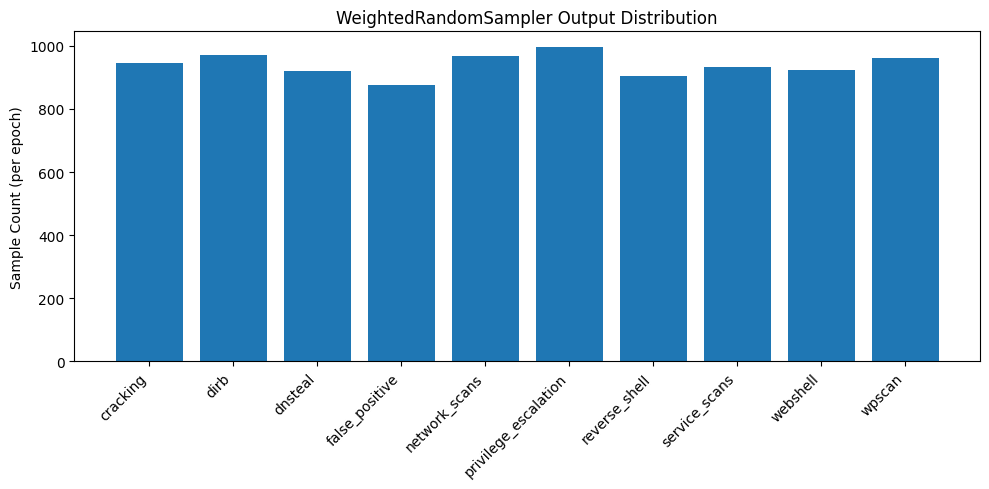

In [4]:
# --- Verify Weighted Sampler Effect ---
print("\n--- Checking WeightedRandomSampler Sampling Distribution ---")
sampled_indices = list(sampler)  # one full epoch worth of indices
sampled_labels = train_df.iloc[sampled_indices]['label_id'].values

# Count how many times each label was drawn
sample_counts = Counter(sampled_labels)

# Display raw counts
for label_id, count in sorted(sample_counts.items()):
    print(f"Label {label_id} ({id_to_label[label_id]}): sampled {count} times")

# Visual check
plt.figure(figsize=(10, 5))
plt.bar(
    [id_to_label[i] for i in sorted(sample_counts.keys())],
    [sample_counts[i] for i in sorted(sample_counts.keys())]
)
plt.xticks(rotation=45, ha='right')
plt.title("WeightedRandomSampler Output Distribution")
plt.ylabel("Sample Count (per epoch)")
plt.tight_layout()
plt.show()

In [5]:
# --- DATALOADERS ---
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

print(f"Train graphs: {len(train_dataset)}, Val graphs: {len(val_dataset)}, Test graphs: {len(test_dataset)}")

Train graphs: 9399, Val graphs: 1659, Test graphs: 1952


In [6]:
# --- FOCAL LOSS ---
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss)
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


# --- GNN MODEL ---
class GNNClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        return self.classifier(x)


# --- TRAIN & EVAL FUNCTIONS ---
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    scaler = torch.amp.GradScaler('cuda')

    for batch in tqdm(loader, desc="Training", leave=False):
        batch = batch.to(Config.DEVICE)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda'):
            out = model(batch)
            loss = criterion(out, batch.y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * batch.num_graphs
        torch.cuda.empty_cache()

    return total_loss / len(loader.dataset)


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", leave=False):
            try:
                batch = batch.to(Config.DEVICE)
                with torch.amp.autocast('cuda'):
                    out = model(batch)
                    loss = criterion(out, batch.y)

                total_loss += loss.item() * batch.num_graphs
                preds = out.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch.y.cpu().numpy())

            except torch.cuda.OutOfMemoryError:
                print("OOM — running this batch on CPU.")
                torch.cuda.empty_cache()
                batch = batch.to("cpu")
                with torch.amp.autocast(device_type="cpu", enabled=False):
                    out = model(batch)
                    loss = criterion(out, batch.y)
                total_loss += loss.item() * batch.num_graphs
                preds = out.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch.y.cpu().numpy())

            finally:
                if Config.DEVICE == "cuda":
                    torch.cuda.empty_cache()

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, all_preds, all_labels

In [7]:
# --- INITIALIZE MODEL, LOSS, OPTIMIZER ---
# alpha_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float).to(Config.DEVICE)
# criterion = FocalLoss(alpha=alpha_tensor, gamma=2.0)
criterion = torch.nn.CrossEntropyLoss()
print("Using Focal Loss with class weighting")

model = GNNClassifier(
    in_channels=train_dataset[0].x.shape[1],
    hidden_channels=Config.HIDDEN_CHANNELS,
    out_channels=num_classes
).to(Config.DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

# --- TRAINING LOOP ---
print("\n--- Starting Training ---")
best_val_loss = float('inf')

for epoch in range(1, Config.EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "graph_sage_classifier.pth")
        print("Best model saved!")

print("\nTraining Finished.")

Using Focal Loss with class weighting


/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



--- Starting Training ---


Training:   0%|          | 0/2350 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 01 | Train Loss: 1.4219 | Val Loss: 1.6055 | Val Acc: 0.5262
Best model saved!


Training:   0%|          | 0/2350 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 02 | Train Loss: 1.2030 | Val Loss: 1.5392 | Val Acc: 0.4937
Best model saved!


Training:   0%|          | 0/2350 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 03 | Train Loss: 1.1341 | Val Loss: 1.3033 | Val Acc: 0.7022
Best model saved!


Training:   0%|          | 0/2350 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 04 | Train Loss: 1.0945 | Val Loss: 1.5475 | Val Acc: 0.2544


Training:   0%|          | 0/2350 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 05 | Train Loss: 1.0630 | Val Loss: 1.5389 | Val Acc: 0.3044


Training:   0%|          | 0/2350 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 06 | Train Loss: 1.0334 | Val Loss: 1.4508 | Val Acc: 0.5359


Training:   0%|          | 0/2350 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 07 | Train Loss: 1.0296 | Val Loss: 1.4664 | Val Acc: 0.5564


Training:   0%|          | 0/2350 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 08 | Train Loss: 0.9865 | Val Loss: 1.3494 | Val Acc: 0.5419


Training:   0%|          | 0/2350 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 09 | Train Loss: 1.0004 | Val Loss: 1.6038 | Val Acc: 0.2176


Training:   0%|          | 0/2350 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
                                                             

Epoch 10 | Train Loss: 0.9642 | Val Loss: 1.3967 | Val Acc: 0.4569

Training Finished.


In [8]:
print("\n--- Evaluating on Test Set ---")
model.load_state_dict(torch.load("graph_sage_classifier.pth"))

test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


--- Evaluating on Test Set ---


Evaluating:   0%|          | 0/488 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 


--- Classification Report ---
                      precision    recall  f1-score   support

            cracking       0.00      0.00      0.00         7
                dirb       0.98      0.94      0.96        54
             dnsteal       0.00      0.00      0.00         8
      false_positive       0.98      1.00      0.99      1860
       network_scans       0.00      0.00      0.00         4
privilege_escalation       0.00      0.00      0.00         3
       reverse_shell       0.00      0.00      0.00         2
       service_scans       0.88      0.78      0.82         9
            webshell       0.00      0.00      0.00         2
              wpscan       0.00      0.00      0.00         3

            accuracy                           0.98      1952
           macro avg       0.28      0.27      0.28      1952
        weighted avg       0.97      0.98      0.97      1952


--- Confusion Matrix ---


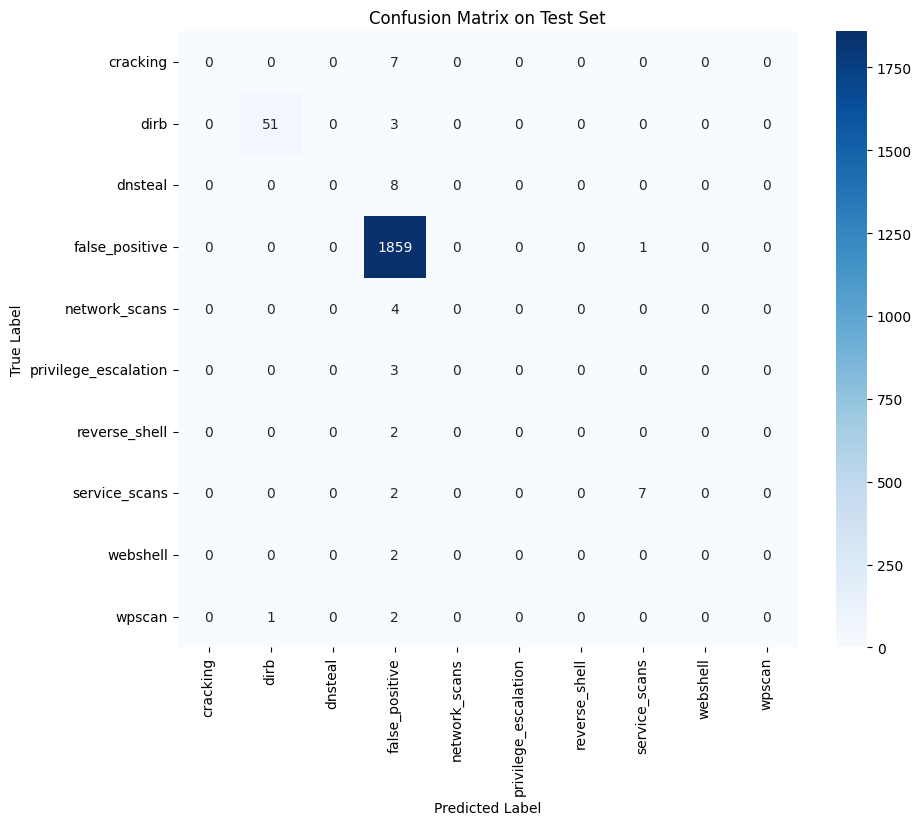

In [ ]:
# --- Classification Report ---
unique_labels = sorted(set(test_labels))
report = classification_report(
    test_labels,
    test_preds,
    labels=unique_labels,
    target_names=[class_names[i] for i in unique_labels],
    zero_division=0,
    digits=3
)
print("\n--- Classification Report ---")
print(report)

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(test_labels, test_preds, labels=unique_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize per true class

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Raw confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[class_names[i] for i in unique_labels],
    yticklabels=[class_names[i] for i in unique_labels],
    ax=ax[0]
)
ax[0].set_title("Raw Confusion Matrix")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")

# Normalized confusion matrix
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap='YlGnBu',
    xticklabels=[class_names[i] for i in unique_labels],
    yticklabels=[class_names[i] for i in unique_labels],
    ax=ax[1]
)
ax[1].set_title("Normalized Confusion Matrix")
ax[1].set_xlabel("Predicted Label")
ax[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()
